In [31]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import speclite.filters
from tqdm import tqdm

from mejiro.instruments.roman import Roman

import sys
sys.path.append('/grad/bwedig/roman_notebooks/content/notebooks/pandeia')
import rbt

In [27]:
# Number of equal-area chunks
n_chunks = 1000

# Healpix requires nside parameter; number of pixels = 12 * nside^2
# Find closest nside that gives ~100 pixels
nside = int(np.sqrt(n_chunks / 12))
npix = hp.nside2npix(nside)
print(f"Using nside={nside}, total pixels={npix}")

# Get pixel centers in RA/Dec
theta, phi = hp.pix2ang(nside, np.arange(npix))
# theta = colatitude (0 at north pole), phi = longitude
ra = np.degrees(phi)  # RA in degrees
dec = np.degrees(0.5*np.pi - theta)  # Dec in degrees

# Store central coordinates
coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

Using nside=9, total pixels=972


In [28]:
fluxes = []

for coord in tqdm(coords):
    bg = rbt.background(coord.ra.deg, coord.dec.deg, wavelength=1.)  # wavelength only matters for bathtub
    # bg_wvl = bg.bkg_data['wave_array'][50]  # 0.85 microns
    bg_flux = np.mean(bg.bkg_data['total_bg'][:, 50])  # average over all days at 0.85 microns
    fluxes.append((coord.ra.deg, coord.dec.deg, bg_flux))

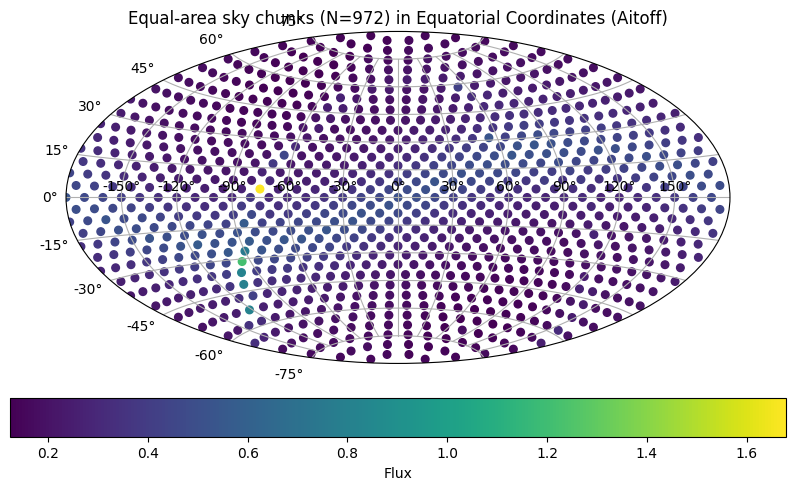

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='aitoff')

# Prepare arrays for plotting
ra_vals = []
dec_vals = []
flux_vals = []

for ra, dec, flux in fluxes:
    # Aitoff projection requires RA in [-180, 180] degrees
    ra_wrapped = ((ra + 180) % 360) - 180
    ra_vals.append(np.radians(ra_wrapped))
    dec_vals.append(np.radians(dec))
    flux_vals.append(flux)

scatter = ax.scatter(ra_vals, dec_vals, s=30, c=flux_vals, cmap='viridis', marker='o')
ax.set_title(f"Equal-area sky chunks (N={npix}) in Equatorial Coordinates (Aitoff)")
ax.grid(True)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.08, shrink=0.8)
cbar.set_label('Flux')

# Set x-ticks in degrees for readability
xticks_deg = np.array([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
ax.set_xticks(np.radians(xticks_deg))
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

plt.tight_layout()
plt.show()

In [32]:
roman = Roman()

filters = roman.load_speclite_filters()

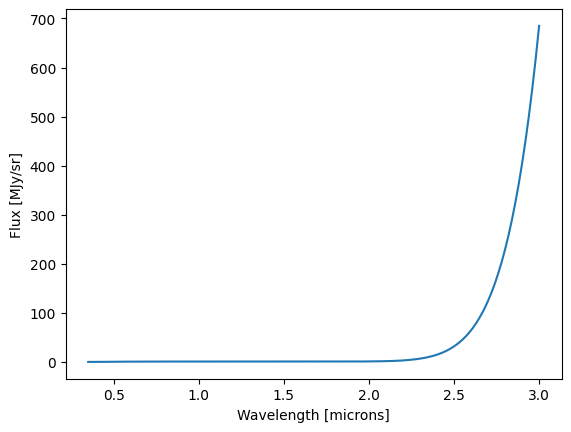

In [51]:
bg = rbt.background(266, -29, wavelength=1.)  # wavelength only matters for bathtub
wlen = bg.bkg_data['wave_array'] * u.micron
flux = np.mean(bg.bkg_data['total_bg'], axis=0) * u.MJy / u.sr  # average over all days

plt.plot(wlen, flux)
plt.xlabel('Wavelength [microns]')
plt.ylabel('Flux [MJy/sr]')
plt.show()

In [52]:
# Step 1: Define pixel solid angle (example for a square pixel)
pixel_scale = 0.11 * u.arcsec
pixel_area = (pixel_scale)**2
pixel_solid_angle = pixel_area.to(u.sr)
print(f"Pixel solid angle: {pixel_solid_angle}")

# Convert surface brightness to flux density
flux_density_nu = flux * pixel_solid_angle  # Now in MJy

# Convert flux from MJy/sr to erg/(Angstrom s cm2)
# First convert to spectral flux density per unit frequency
flux_per_freq = flux_density_nu.to(u.erg / (u.s * u.cm**2 * u.Hz))

# Convert from per frequency to per wavelength: F_lambda = F_nu * c / lambda^2
# Using astropy's spectral_density equivalency
flux_per_wlen = flux_per_freq.to(u.erg / (u.s * u.cm**2 * u.Angstrom), 
                                   equivalencies=u.spectral_density(wlen))

mags = filters.get_ab_magnitudes(flux_per_wlen, wlen).as_array()

Pixel solid angle: 2.844036095230844e-13 sr


In [53]:
print(mags)

[(25.79985318, 25.54103531, 25.51288485, 25.5098534, 25.4954803, 25.49280145, 25.46326223, 24.22791531)]
